# <center> Expectation Maximization for Gaussian Mixture Model</center>

<ul>
    <li> <b>Coursebook Link</b>: https://www.nmr.mgh.harvard.edu/~koen/ex/mia.pdf#page=96
    <li> <b>Description</b>: Solution of Exercise VIII. In this exercise we estimate the maximum likelihood parameters of a 3- component Gaussian mixture model for a brain MR scan, using the expectation maximization algorithm.
    <li> <b>Created By</b>: Rimmon Saloman Bhosale
    <li> <b>Date</b>: February 8, 2024
    <Requirements:>:
        <ul>
            <li> Python 3.9
            <li> numpy 1.26.3
            <li> scipy 1.11.3
            <li> matplotlib 3.5.3
        </ul>
</ul>

#### Load required libraries

In [1]:
import copy
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

#### Set a few Configuration Parameters

In [2]:
# Number of components in the Gaussian Mixture Model (GMM)
num_components = 3
# Number of epochs/iterations to update the GMM parameters
num_epochs = 101

#### Utility Functions

In [3]:
def show_plots(title="Output",x_label=None,y_label=None,show_axis=True,display_plot=True):
    """
    Description:
        This function sets a few plt parameters and displays the image
    Parameters:
        title: Title of the plot
        x_label: Label for the X-axis
        y_label: Label for the Y-axis
        show_axis: Decides if the axis is to be shown
    Returns:
        None
    """
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    if not show_axis:
        plt.axis('off')
    plt.legend()
    if display_plot:
        plt.show()      

def plot_image(image) -> None:
    """
    Description:
        This Function plots the input image.
    Parameters:
        image: the input 2D image
    Returns:
        None
    """
    plt.imshow(image,cmap='gray')

def plot_histogram(X):
    """
    Description:
        This function plots the histogram of the flattened input image
    Parameters:
        X : The flattened input image
    Returns:
        None
    """
    hist, bins, _ = plt.hist(X, bins=256, color='blue', alpha=0.0, density=True)
    bin_centers = [np.mean((bins[i],bins[i-1])) for i in range(1,len(bins))]
    plt.plot(bin_centers,hist,label="histogram")


def plot_gmm(X,num_components,means,variances,prior_weights):
    """
    Description:
        This function plots the gaussian mixtures
    Parameters:
        X : Flattened image data
        num_components : Number of components (K) in the GMM
        means : The means (µ_k) of the GMM
        variances : The variances (σ^2_k) of the GMM prior_weights : The prior weights (π_k) of the GMM
        prior_weights : The prior weights (π_k) of the GMM
    Returns:
        None
    """
    xs,ys_list,ys_mixture = mixture_of_gaussian(X,num_components,means,variances,prior_weights)
    for k,ys in enumerate(ys_list):
        plt.plot(xs,ys,label=f'Component {k + 1} ({round(means[k],2)},{round(variances[k],2)})')
    plt.plot(xs,ys_mixture, color = 'k', linestyle='--',label=f'Total Mixture')

def calculate_intensity_range(X):
    """
    Description:
        This function calculates the minimum and maximum intensity values
    Parameters:
        X : The flattened input image
    Returns:
        minimum_intensity: Minimum intensity values
        maximum_intensity: Maximum intensity values
    """
    minimum_intensity = np.nanmin(X)
    maximum_intensity = np.nanmax(X)
    return minimum_intensity,maximum_intensity

def get_intervals(minimum_intensity,maximum_intensity,num_components):
    """
    Description:
        This function divides the pixel intensities into num_component bins
    Parameters:
        minimum_intensity: Minimum intensity values
        maximum_intensity: Maximum intensity values
        num_components: Number of components in the GMM
    Returns:
        interval_width: width of the generated intervals
        intensity_bins: range of the various intensity bins
    """
    interval_width = (maximum_intensity-minimum_intensity)//num_components
    intensity_bins = []
    start = minimum_intensity
    for k in range(num_components):
        end = start+interval_width
        intensity_bins.append([start,end])
        start = end
    return interval_width,intensity_bins

def initialize_gmm_parameters(interval_width,intensity_bins):
    """
    Description:
        This function initializes the means, variances and prior weights of the gmm
    Parameters:
        interval_width: width of the generated intervals
        intensity_bins: range of the various intensity bins
    Returns:
        means : The means (µ_k) of the GMM
        variances : The variances (σ^2_k) of the GMM
        prior_weights : The prior weights (π_k) of the GMM
    """
    gmm_means = np.zeros((num_components))
    gmm_variances = np.zeros((num_components))
    prior_weights = np.zeros((num_components))
    for k in range(num_components):
        gmm_means[k] = np.mean(intensity_bins[k])
        gmm_variances[k] = interval_width**2
        prior_weights[k] = 1/num_components
    return gmm_means,gmm_variances,prior_weights

def plot_prior_weights(weights,num_components,title="Weights over Iterations") -> None:
    """
    Description: 
        This function plots the evolution of prior weights (π_k) over the iterations of EM algorithm
    Parameters:
        weights: Weights array of the shape (num_components,flattened_image_size)
        num_components: Number of components in the GMM
    Returns:
        None
    """
    # Setting the figure size
    plt.figure(figsize=(10,5))
    for k in range(num_components):
        # Plotting the prior weights of component k
        plt.plot(np.arange(len(weights)), weights[:,k], marker='o', label=f'Component {k + 1}')
        
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Weight')
    plt.legend()
    plt.show()

def plot_individual_weights(X,weights) -> None:
    """
    Description:
        This function plots the individual weights (w^i_k's) for each pixel i in the flattened image and component k in the GMM
    Parameters:
        weights: Weights array of the shape (num_components,flattened_image_size)
    Return:
        None
    """
    num_components,size = weights.shape
    
    for k in range(num_components):
        plt.scatter(X,weights[k],label=f'$w^i_{k}$')



#### Core Functions

In [4]:
def gaussian_pdf(X,mean,variance):
    """
    Description:
        This function calculates the likelihood of the image wrt to the given gaussian
    Parameters:
        X : Flattened image data
        means : The means (µ_k) of the GMM
        variances : The variances (σ^2_k) of the GMM prior_weights : The prior weights (π_k) of the GMM
    Returns:
        likelihood : likelihood value for each element of X wrt the given gaussian distribution
    """
    likelihood = ((1 / np.sqrt(2 * np.pi * variance)) *  
        np.exp( -((X - mean)**2)/(2 * variance)))
    return likelihood


def mixture_of_gaussian(X,num_components,means,variances,prior_weights):
    """
    Description:
        This function calculates the mixture of multiple gaussians
    Parameters:
        X : Flattened image data
        num_components : Number of components (K) in the GMM
        means : The means (µ_k) of the GMM
        variances : The variances (σ^2_k) of the GMM prior_weights : The prior weights (π_k) of the GMM
        prior_weights : The prior weights (π_k) of the GMM
    Returns:
        xs : Sampled x values
        ys_list : list containing likelihoods wrt different components
        ys_mixture : mixture of num_component gaussians
    """
    xs = np.linspace(
        np.nanmin(X)-np.sqrt(max(variances)),
        np.nanmax(X)+np.sqrt(max(variances)),
        len(X)
    )
    ys_list = np.zeros((num_components,len(xs)))
    ys_mixture = np.zeros_like(xs)
    for k in range(num_components):
        ys_list[k] = gaussian_pdf(xs,means[k],variances[k])*prior_weights[k]
        ys_mixture += ys_list[k]
    
    return xs,ys_list,ys_mixture

def compute_weights(X,num_components,means,variances,prior_weights) -> (np.array,np.array):
    """
    Description:
        This function updates the weights (w^i_k) for the given image and the GMM
    Parameters:
        X : Flattened image data
        num_components : Number of components (K) in the GMM
        means : The means (µ_k) of the GMM
        variances : The variances (σ^2_k) of the GMM prior_weights : The prior weights (π_k) of the GMM
    Returns:
        weights : Array of the size ((num_components,len(X))) representing weights w^i_k
        likelihood : Array of the size ((num_components,len(X))) representing the likelihood values of each pixel in the image belonging to component k
    """
    # Initialize the likelihood values to 0's
    likelihoods = np.zeros((num_components,len(X)))

    # Calculate the likelihood values (p(d|θ)) wrt each component in GMM
    for k in range(num_components):
        likelihoods[k] = gaussian_pdf(X,means[k],variances[k])*prior_weights[k]

    # Updating the weights (w^i_k) as described in Eq. 4.33 of the book   
    weights = likelihoods/np.nansum(likelihoods,axis=0)
    
    return weights

def update_parameters(X,weights):
    """
    Description:   
        This function performs the maximization step of the EM algorithm
    Parameters:
        X : Flattened image data
        weights : Array of the size ((num_components,len(X))) representing weights w^i_k
    Returns:
        new_means : Updated mean values of the GMM
        new_variances :Updated variance values of the GMM
        new_prior_weights : Updated prior weight values of the GMM

    """
    # Updating parameters using Eq.4.35 in the book
    new_means = np.nansum(weights*X,axis=1) / (np.nansum(weights,axis=1))
    new_prior_weights = np.nanmean(weights,axis=1) 
    new_variances = np.zeros_like(new_means)
    for k in range(len(weights)):
        new_variances[k] = np.nansum(weights[k] * np.square(X - new_means[k])) / (np.nansum(weights[k]))
    return new_means,new_variances,new_prior_weights


def calculate_log_likelihood(X, num_components, means, variances, prior_weights):
    """
    Description:
        This function computes the log likelihood values
    Parameters:
        X : Flattened image data
        num_components : Number of components (K) in the GMM
        means : The means (µ_k) of the GMM
        variances : The variances (σ^2_k) of the GMM prior_weights : The prior weights (π_k) of the GMM
        prior_weights : The prior weights (π_k) of the GMM
    Returns:
        The log likelihood values : A scalar value representing the log likelihood
    """
    # Calculate the likelihoods
    likelihoods = np.zeros((num_components,len(X)))
    for k in range(num_components):
        likelihoods[k] = gaussian_pdf(X,means[k],variances[k])*prior_weights[k]

    # Computing the sum of likelihoods across 0th axis and ignoring the 0 values to avoid issue with log caluclation
    likelihoods_summed = np.nansum(likelihoods, axis=0)
    likelihoods_summed[likelihoods_summed==0] = np.NAN

    # Summing the likelihoods across the k components
    log_likelihood_values = np.nansum(np.log(likelihoods_summed))

    return log_likelihood_values

def calculate_lower_bound(X, num_components, means, variances, prior_weights,weights):
    """
    Description:
        This function calculates the lowerbound as defined in Eq. 4.32
    Parameters:
        X : Flattened image data
        num_components : Number of components (K) in the GMM
        means : The means (µ_k) of the GMM
        variances : The variances (σ^2_k) of the GMM prior_weights : The prior weights (π_k) of the GMM
        prior_weights : The prior weights (π_k) of the GMM
        weights: Weights array of the shape (num_components,flattened_image_size)
    Returns:
        lower_bound_value : A scalar value 
        new_means : Updated mean values
    """
    # Computing the likelihoods for the k components using the given parameters and the input X
    likelihoods = np.zeros((num_components,len(X)))
    for k in range(num_components):
        likelihoods[k] = gaussian_pdf(X,means[k],variances[k])*prior_weights[k]
    
    # Computing the lower bound
    lower_bound = np.nansum(
            np.multiply(
                weights,
                np.log(
                    likelihoods/weights
                )
            )
        )
    return lower_bound

## 1. Display the image and plot its histogram.

In [5]:
# Read the input file
input_image = np.array(loadmat('correctedData.mat').get('correctedData'),dtype=np.float64)

# Flatten the input image into 1D array
flattened_image = input_image.reshape(np.prod(input_image.shape))

# Replace 0's in image by NaN
flattened_image[flattened_image == 0] = np.NAN


### 1.1 Plotting the input image

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


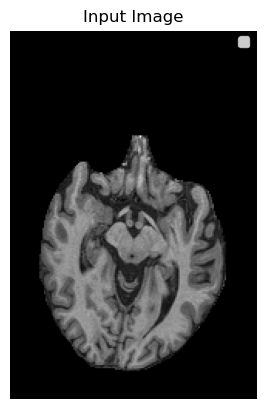

In [6]:
plot_image(input_image)
show_plots("Input Image",x_label="",y_label="",show_axis=False)

### 1.2 Plotting the histogram of the image

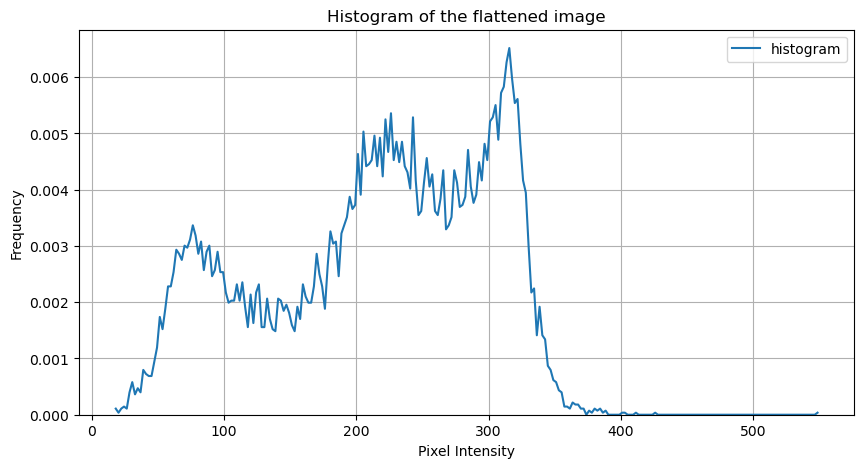

In [7]:
plt.figure(figsize=(10,5))
plot_histogram(flattened_image)
show_plots(title="Histogram of the flattened image",x_label="Pixel Intensity",y_label="Frequency")

## 2. Compute the minimum and maximum intensity in the image (non-zeropixels), and divide the intensity range up into three equally wide intervals. Initialize the parameters of a 3-component Gaussian mixture model by setting the means $µ_k$ of the Gaussians to the centers of the intensity intervals, the variances $σ^2_k$ to the square of the width of the intervals, and the prior weights $π_k$ to 1/3 each.

### 2.1 Computing the minimum and maximum intensities


In [8]:
minimum_intensity, maximum_intensity = calculate_intensity_range(flattened_image)
print("The minimum intensity is: ",minimum_intensity)
print("The maximum intensity is: ",maximum_intensity)

The minimum intensity is:  17.078205010324904
The maximum intensity is:  549.6669350144115


### 2.2 Getting the intensity intervals

In [9]:
interval_width,intensity_bins = get_intervals(minimum_intensity,maximum_intensity,num_components)
print("Interval width : ",interval_width)
print("Intervals : ",intensity_bins)

Interval width :  177.0
Intervals :  [[17.078205010324904, 194.0782050103249], [194.0782050103249, 371.0782050103249], [371.0782050103249, 548.0782050103248]]


### 2.3 Initialize the GMM parameters

In [10]:
gmm_means,gmm_variances,prior_weights = initialize_gmm_parameters(interval_width,intensity_bins)
print("Initial Mean Values : ",gmm_means)
print("Initial Variance Values : ",gmm_variances)
print("Initial Prior Weight Values : ",prior_weights)

Initial Mean Values :  [105.57820501 282.57820501 459.57820501]
Initial Variance Values :  [31329. 31329. 31329.]
Initial Prior Weight Values :  [0.33333333 0.33333333 0.33333333]


## 3. Overlay the resulting Gaussian mixture model on the histogram by plotting each Gaussian weighted by its $π_k$, as well as the total weighted sum of all three Gaussian distributions (as in fig. 4.1(b)).

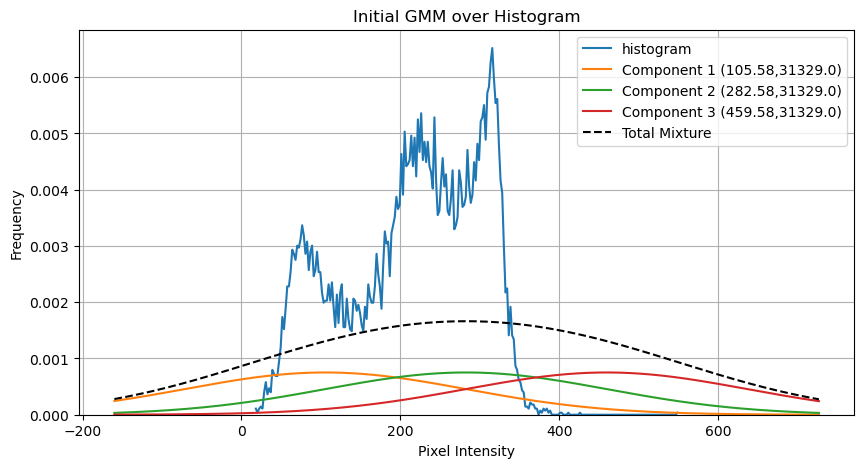

In [11]:
plt.figure(figsize=(10,5))
plot_histogram(flattened_image)
plot_gmm(flattened_image,num_components,gmm_means,gmm_variances,prior_weights)
show_plots(title="Initial GMM over Histogram",x_label="Pixel Intensity",y_label="Frequency")

## 4. Compute and display the values of $w_k^i$ defined by eq. 4.33.

### OBSERVATION:

In the below plot, class weights wrt each pixel can be considered as the weights representing the probabilities of that pixel belonging to a particular gaussian component

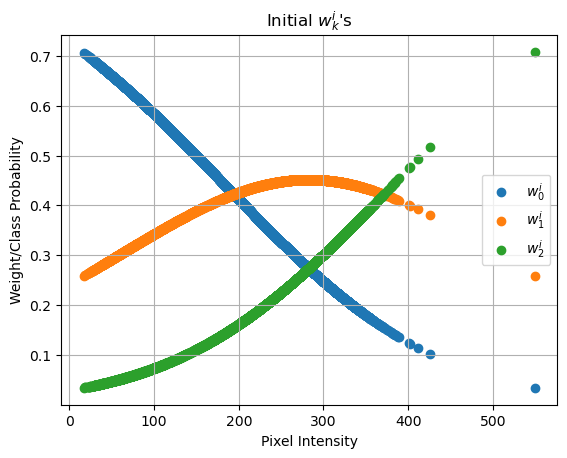

In [12]:
weights = compute_weights(flattened_image,num_components,gmm_means,gmm_variances,prior_weights)
plot_individual_weights(flattened_image,weights)
show_plots(title=f"Initial $w_k^i$\'s", x_label="Pixel Intensity",y_label="Weight/Class Probability")
        

## 5. Estimate the maximum likelihood parameters by iterating between updating the model parameter estimate according to eq. 4.35, and recomputing the $w_k^i$’s according to eq. 4.33. Make sure to perform enough iterations (e.g., 100) for the algorithm to converge. As the iterations progress, plot the evolution of the log likelihood function, and update each time the display of the $w_k^i$ ’s as well as the Gaussian mixture model plot overlaid on the histogram. Include the evolution of the log likelihood function and the plot of the final $w_k^i$ ’s and the final mixture model in your report.

### 5.1 Estimating the Maximum Likelihood parameters and plotting the ovelray of GMM and Histogram after every 10 epochs


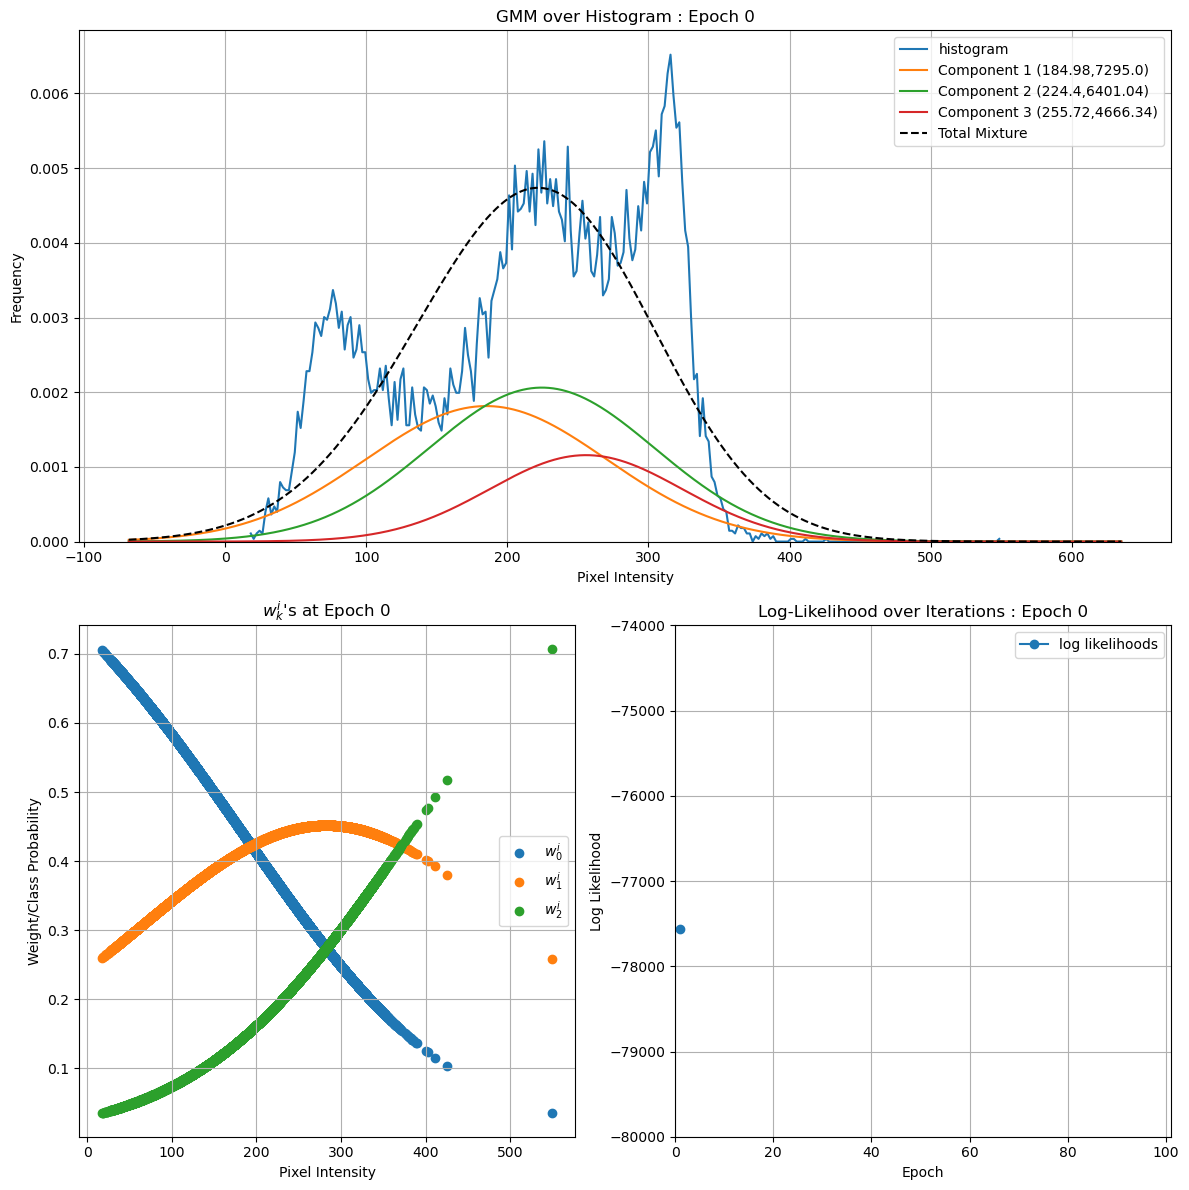

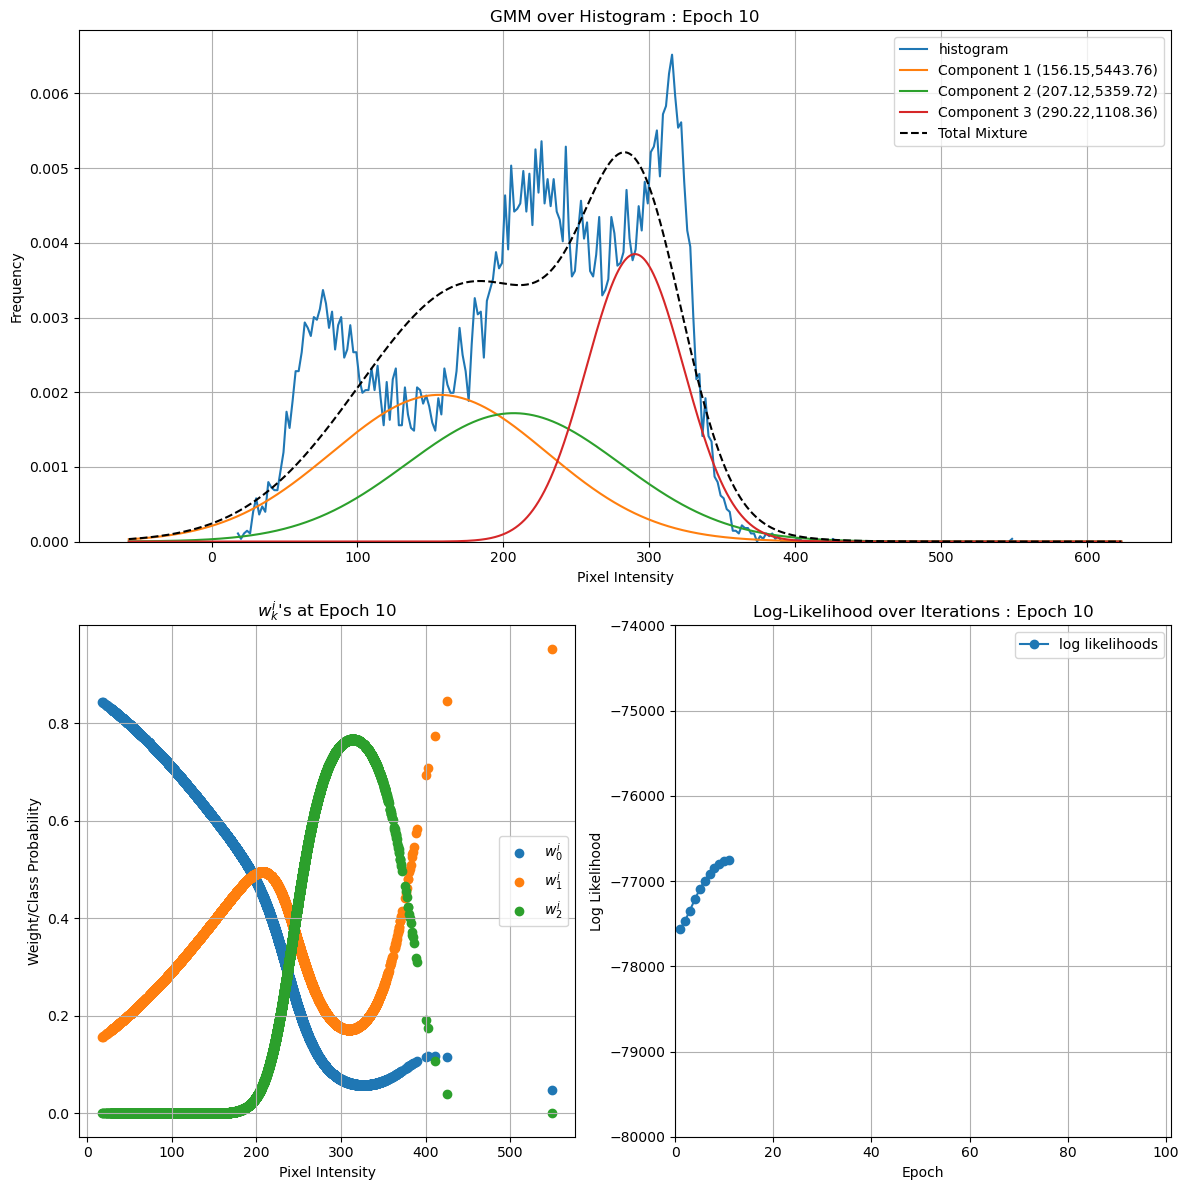

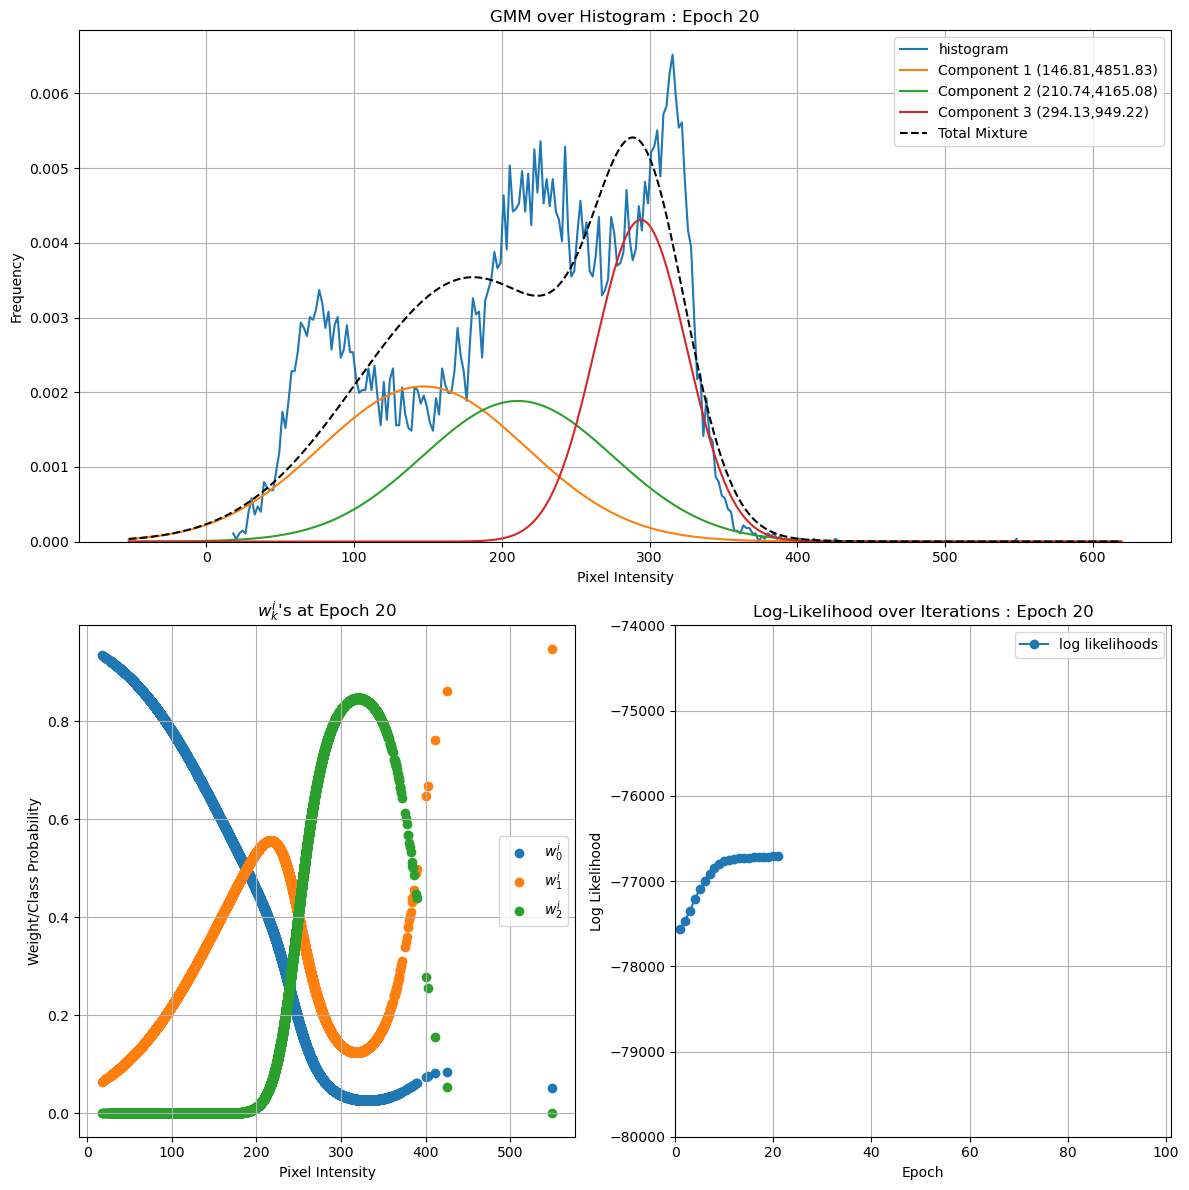

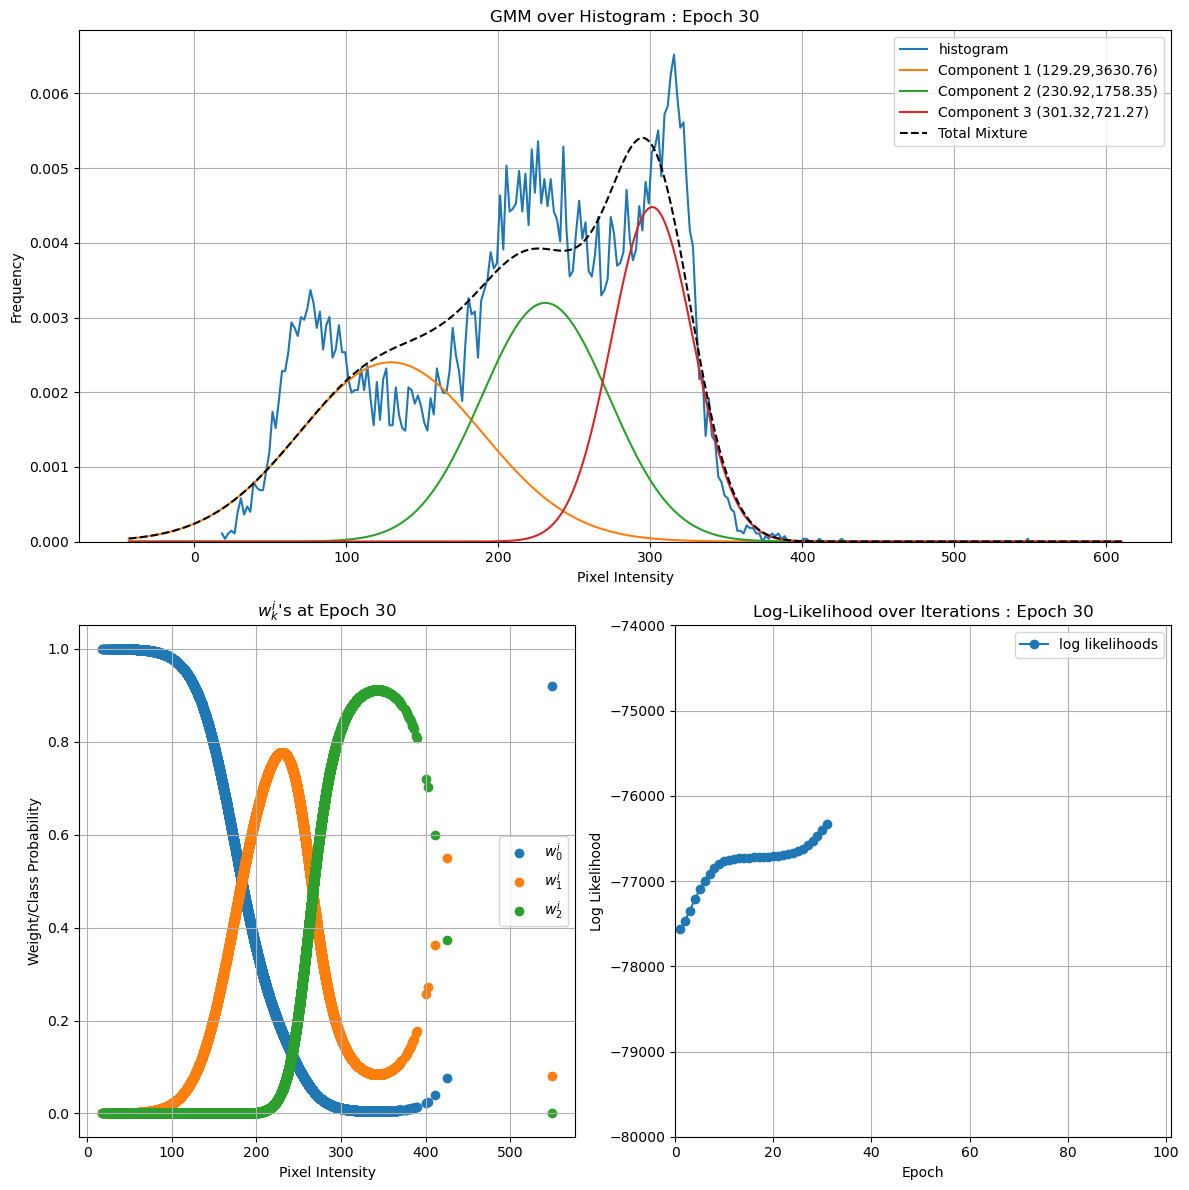

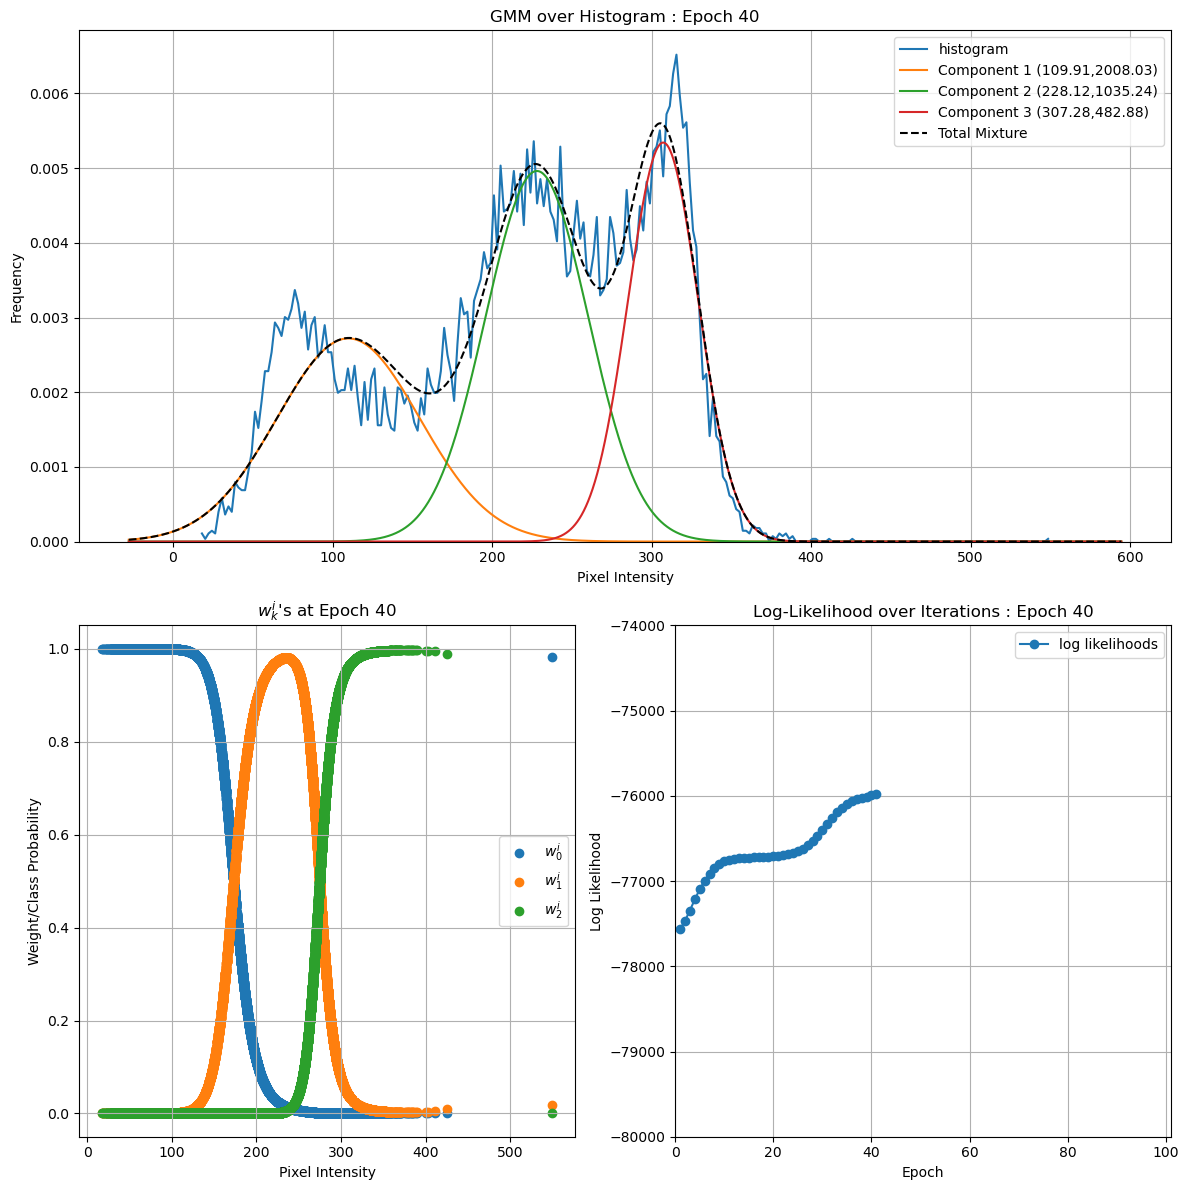

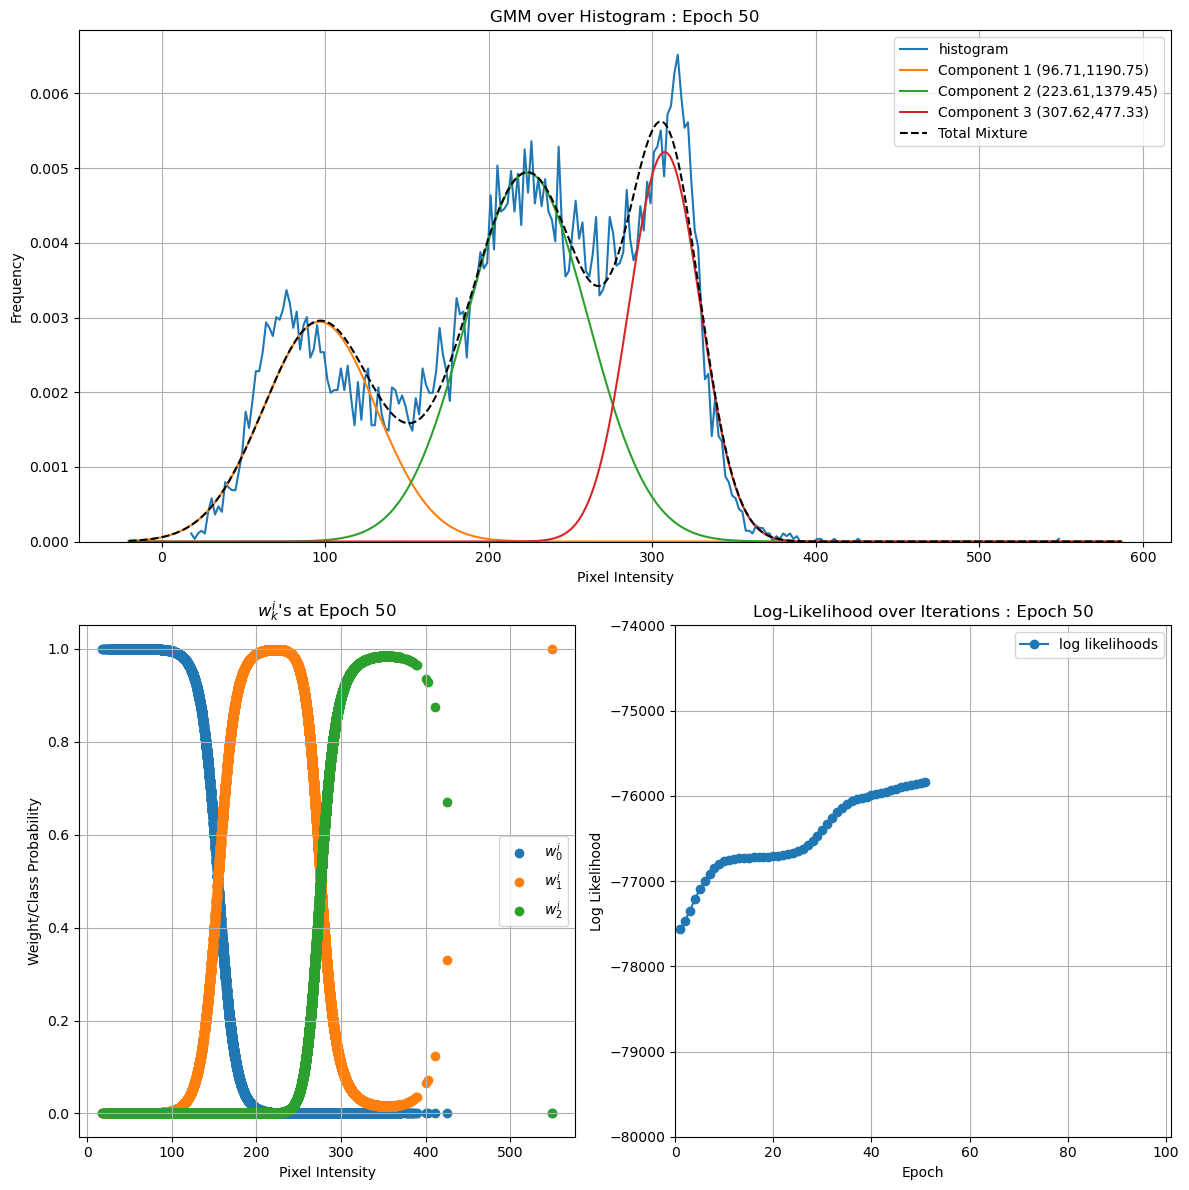

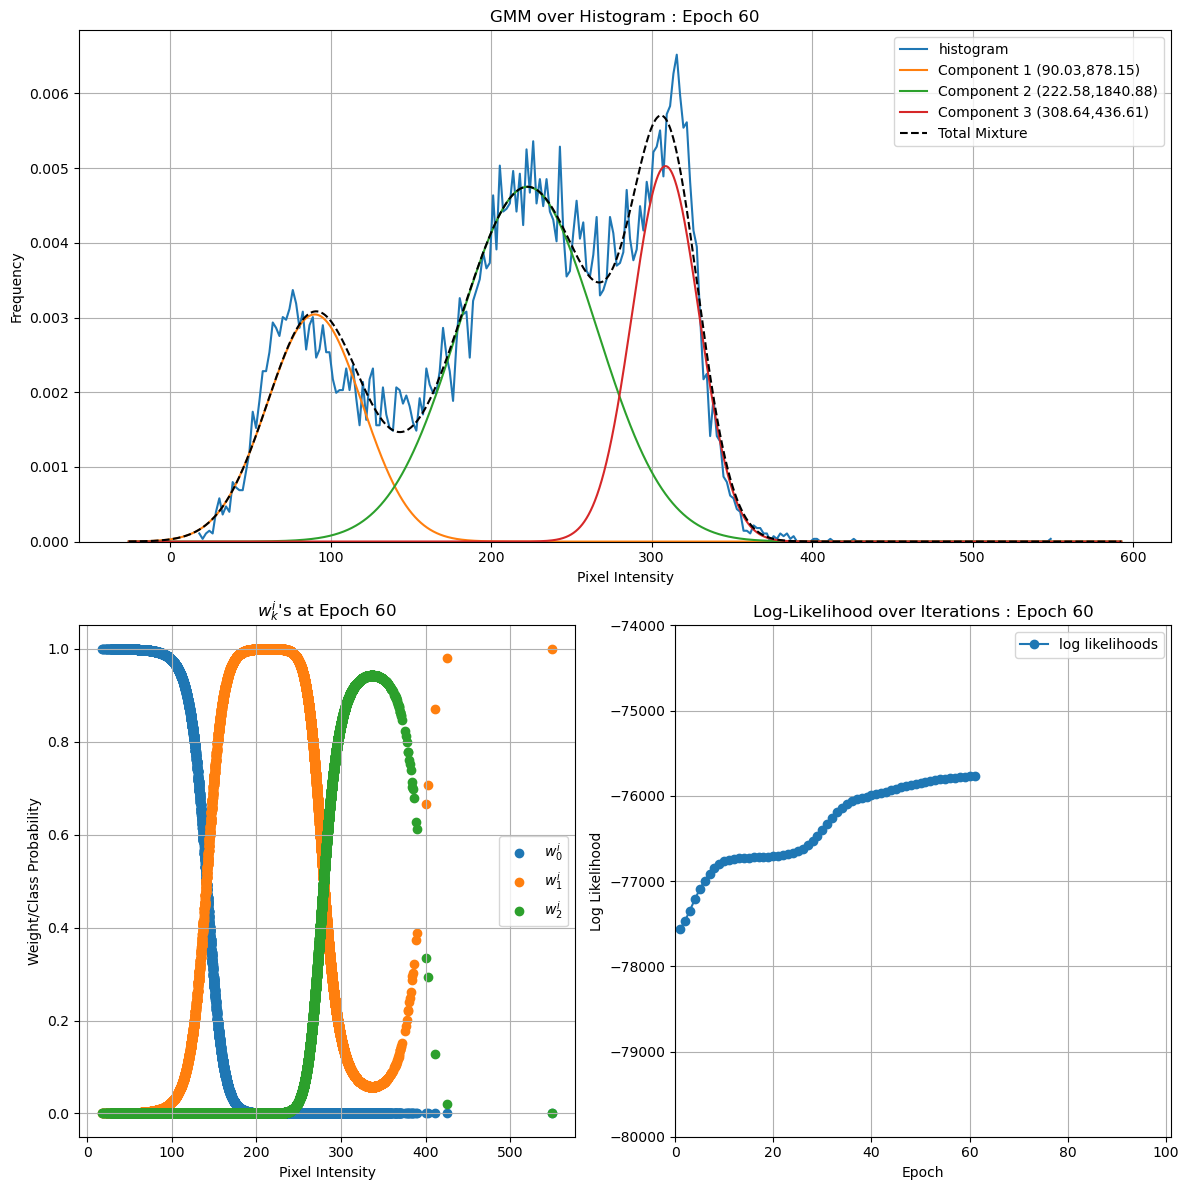

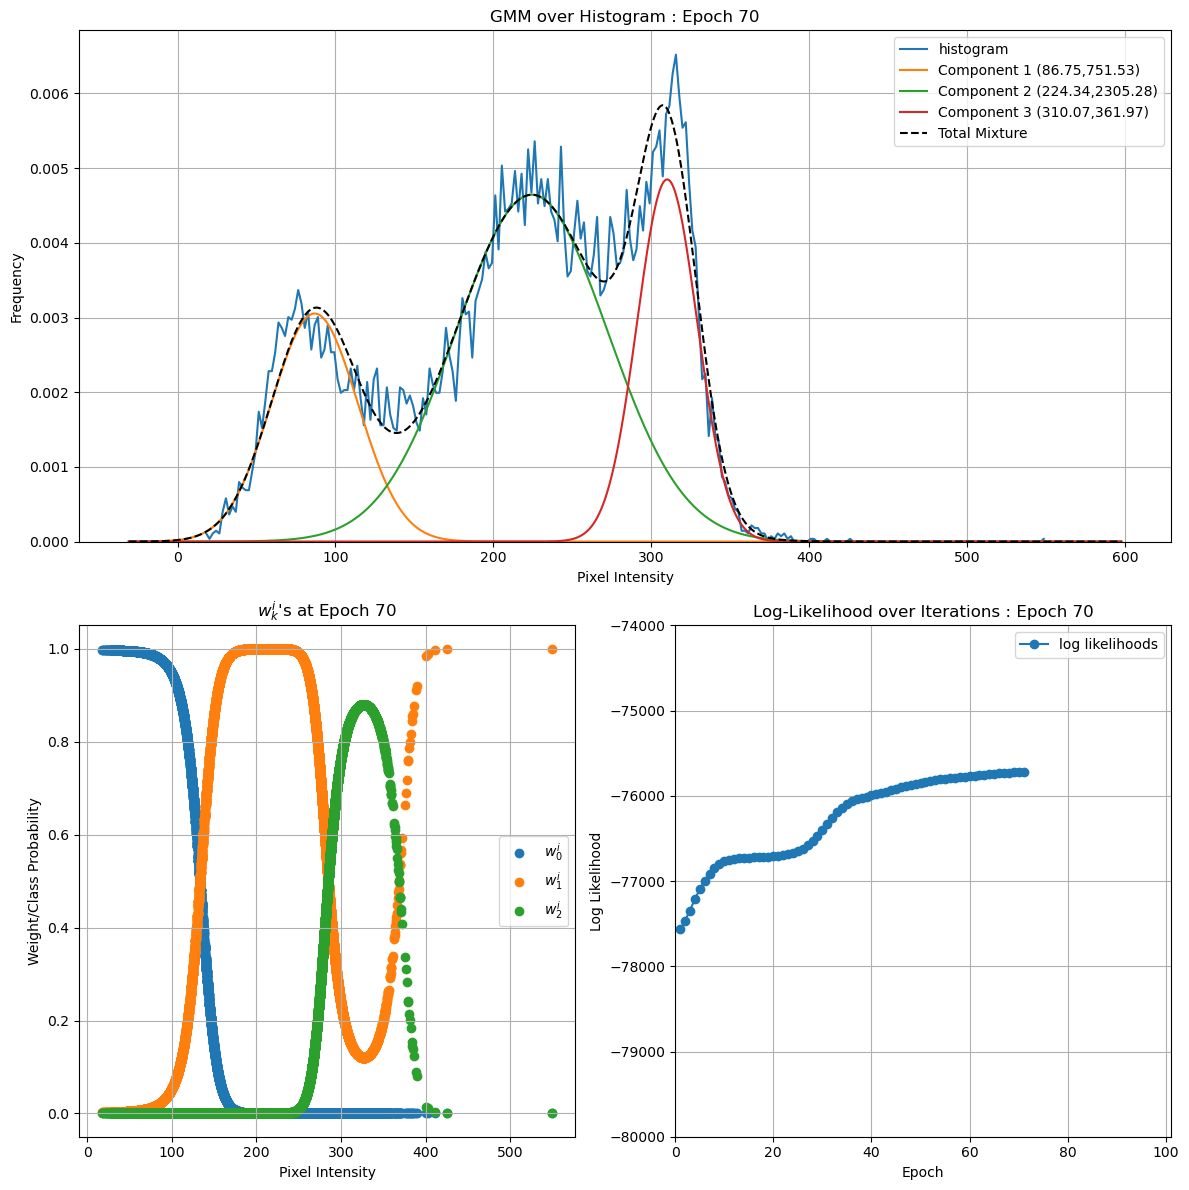

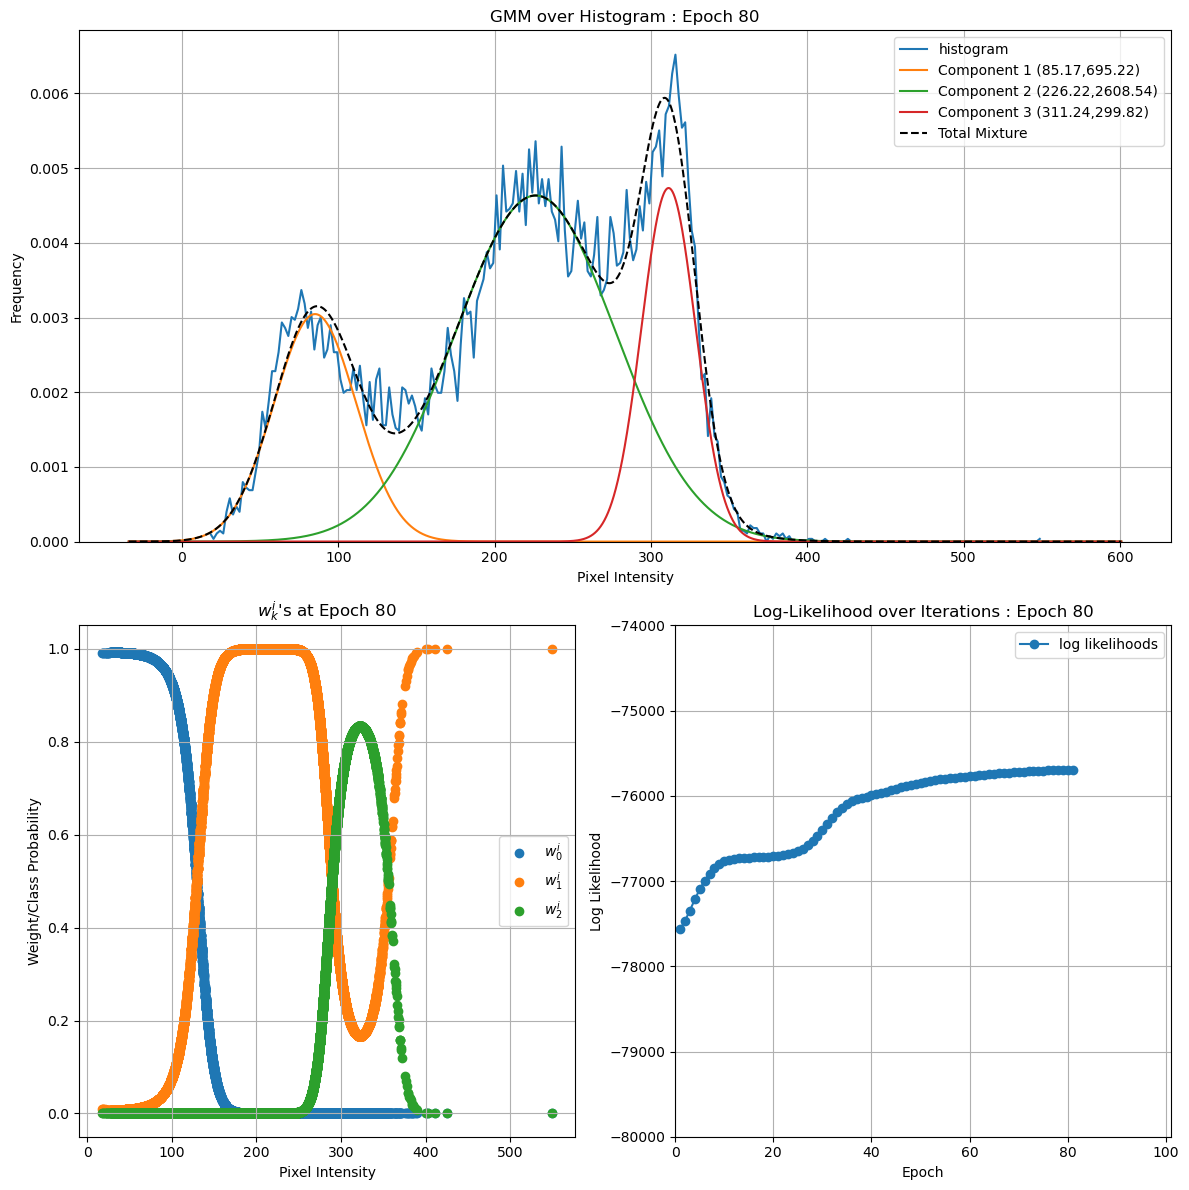

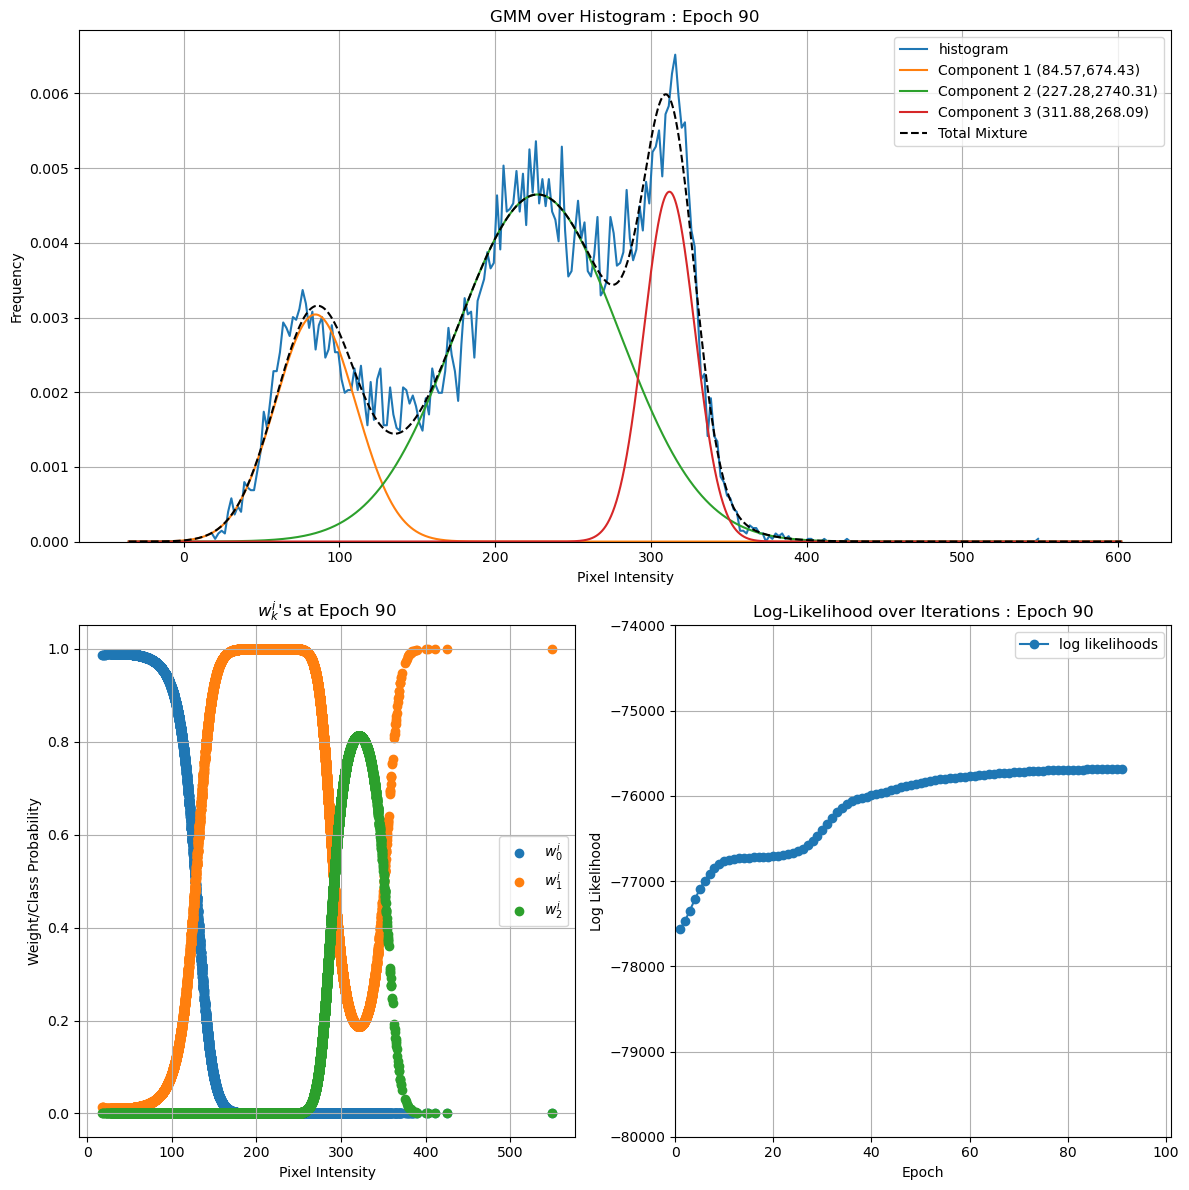

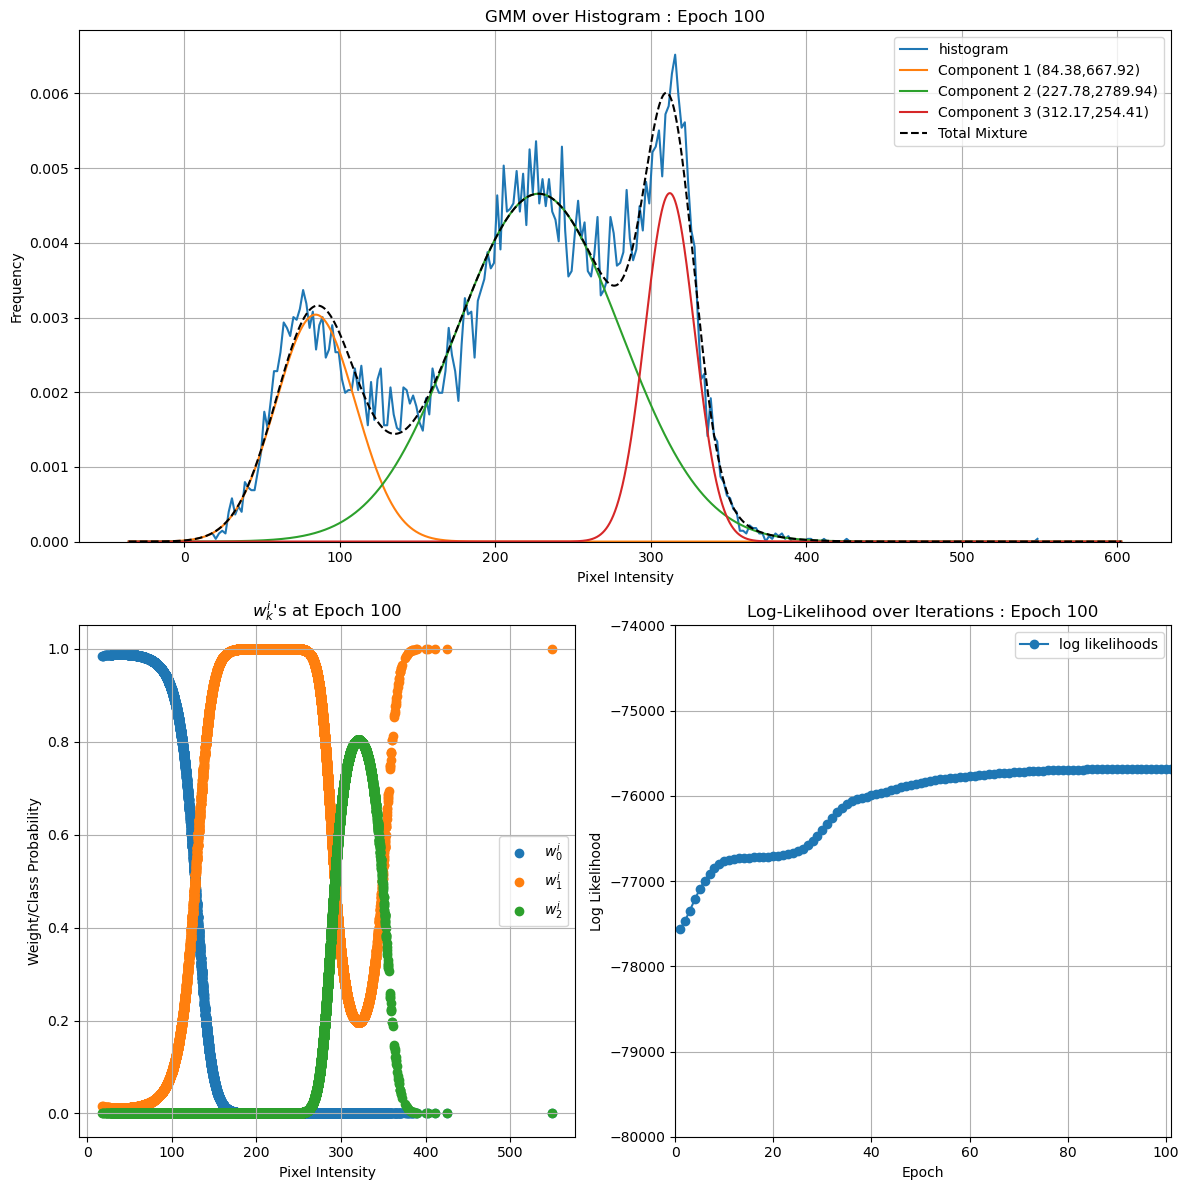

In [13]:
gmm_means,gmm_variances,prior_weights = initialize_gmm_parameters(interval_width,intensity_bins)
prior_weights_over_iterations = [copy.copy(prior_weights)]
max_log_likelihoods_over_iterations = []

for epoch in range(num_epochs):
    weights = compute_weights(flattened_image,num_components,gmm_means,gmm_variances,prior_weights)
    gmm_means,gmm_variances,prior_weights =  update_parameters(flattened_image,weights)
    prior_weights_over_iterations.append(copy.copy(prior_weights))
    max_log_likelihoods_over_iterations.append(calculate_log_likelihood(flattened_image, num_components, gmm_means, gmm_variances, prior_weights))
    if epoch%10==0:
        plt.figure(figsize=(12,12))
        plt.subplot(2,1,1);
        plot_histogram(flattened_image)
        plot_gmm(flattened_image,num_components,gmm_means,gmm_variances,prior_weights)
        show_plots(title=f"GMM over Histogram : Epoch {epoch}",x_label="Pixel Intensity",y_label="Frequency",display_plot=False)
    
        plt.subplot(2,2,3);
        plot_individual_weights(flattened_image,weights)
        show_plots(title=f"$w_k^i$\'s at Epoch {epoch}", x_label="Pixel Intensity",y_label="Weight/Class Probability",display_plot=False)
        
        plt.subplot(2,2,4);
        plt.plot([x+1 for x in range(epoch+1)], max_log_likelihoods_over_iterations, marker='o',label="log likelihoods")
        plt.xlim(0, num_epochs)
        plt.ylim(-80000, -74000)
        show_plots(title=f'Log-Likelihood over Iterations : Epoch {epoch}', x_label="Epoch",y_label="Log Likelihood",display_plot=False)
        plt.tight_layout()
        



### 5.2 Evolution of the log likelihood function


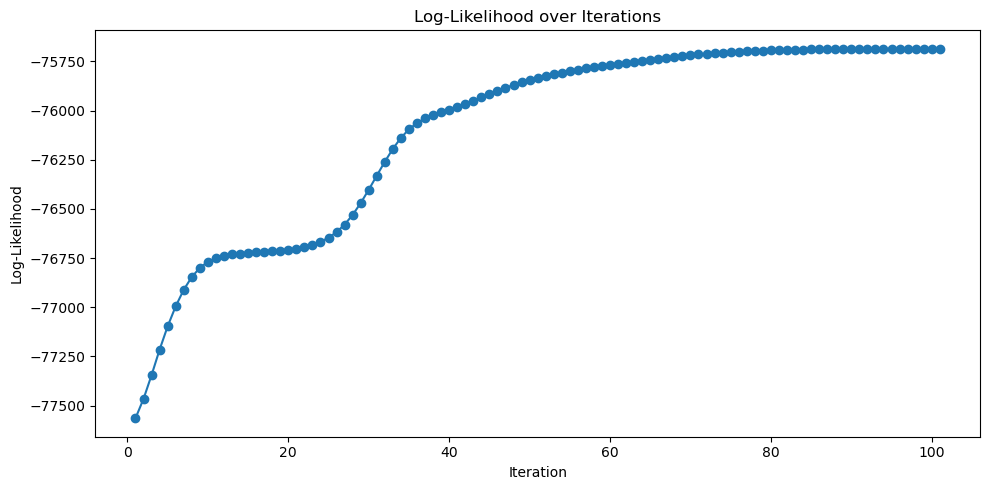

In [14]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, len(max_log_likelihoods_over_iterations) + 1), max_log_likelihoods_over_iterations, marker='o')
plt.title('Log-Likelihood over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.tight_layout()
plt.show()


### 5.3 Evolution of the $\pi_k$
#### Just an additional plot
 



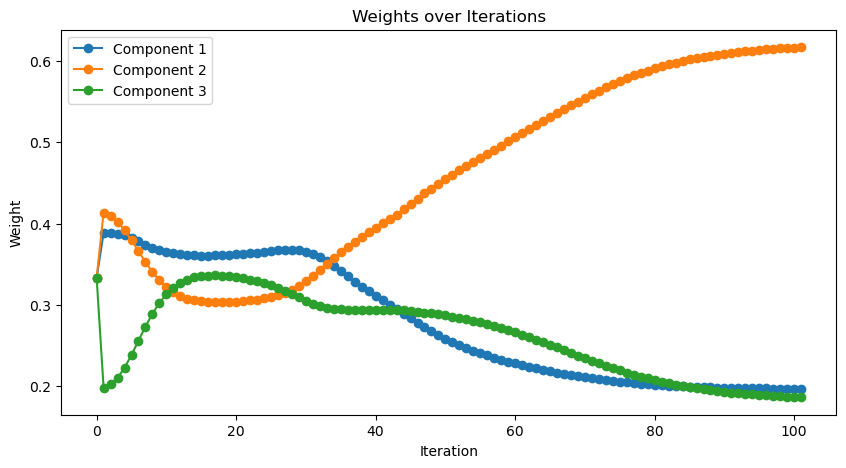

In [15]:
plot_prior_weights(np.array(prior_weights_over_iterations),num_components)


### 5.4 Plot of the final $w^i_k$'s 


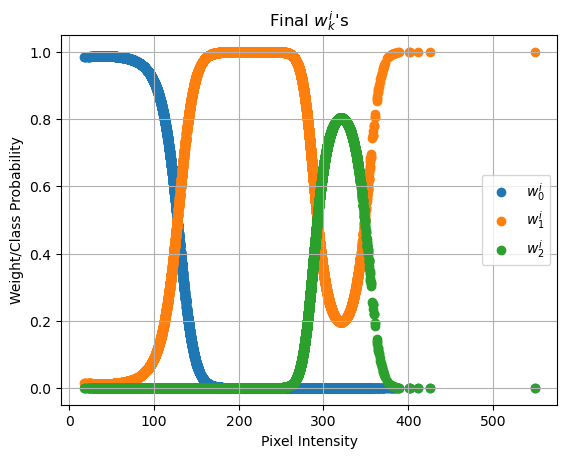

In [16]:
weights = compute_weights(flattened_image,num_components,gmm_means,gmm_variances,prior_weights)
plot_individual_weights(flattened_image,weights)
show_plots(title=f"Final $w_k^i$\'s", x_label="Pixel Intensity",y_label="Weight/Class Probability")

## 6. Keeping all other parameters fixed to their estimated values, vary only $µ_2$ (the mean of the middle Gaussian distribution) between the estimated values of $µ_1$ and $µ_3$ in about 100 steps, and plot for each step the log likelihood function. 

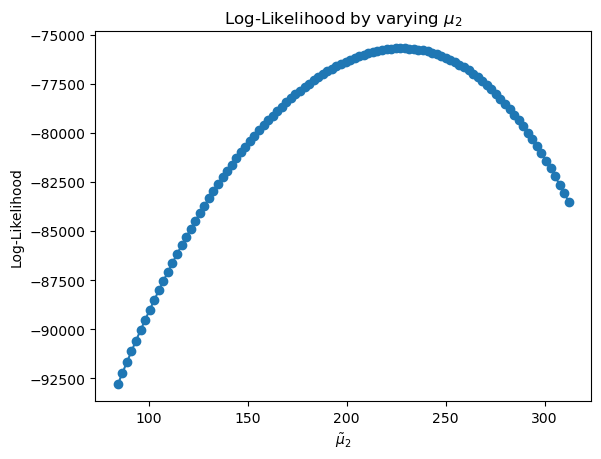

In [17]:
# Solution to Q6
temp_mu_2 = np.linspace(gmm_means[0],gmm_means[2],100)
temp_mean = [x for x in gmm_means]
max_log_likelihoods = []
for mu_2 in temp_mu_2:
    temp_mean[1] = mu_2
    max_log_likelihoods.append(calculate_log_likelihood(flattened_image, num_components, temp_mean, gmm_variances, prior_weights))

plt.plot(temp_mu_2, max_log_likelihoods, marker='o')
plt.title('Log-Likelihood by varying $\\mu_2$')
plt.xlabel('$\\tilde\mu_2$')
plt.ylabel('Log-Likelihood')
plt.show()


## 7. On the same figure, also plot the lower bound $Q(\theta|\tilde{\theta})$ corresponding to the parameter vector $\tilde{\theta}$ in which all parameters are set to their estimated values, except $µ_2$ which is set to the estimated value of $µ_1$.

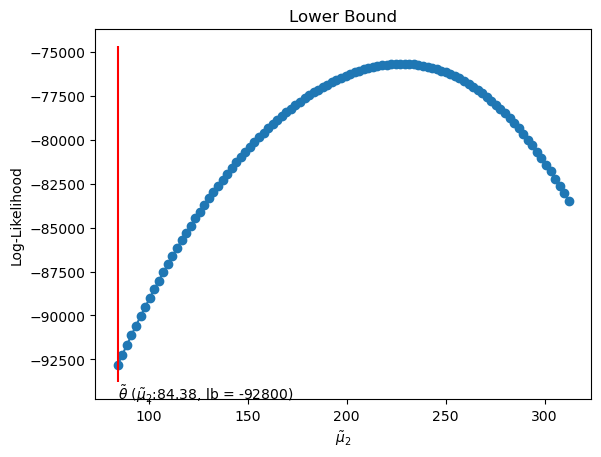

In [18]:

# Solution to Q7 and Q8
temp_mean[1] = temp_mean[0]
lower_bound_value = calculate_lower_bound(flattened_image, num_components, temp_mean, gmm_variances, prior_weights,weights)

plt.plot(temp_mu_2, max_log_likelihoods, marker='o')
plt.vlines(x=temp_mean[1], ymin=min(max_log_likelihoods)-1000, ymax=max(max_log_likelihoods)+1000, colors=['r'])
plt.text(temp_mean[1], min(max_log_likelihoods)-1000, f"$\\tilde\\theta$ ($\\tilde\\mu_2$:{round(temp_mean[1],2)}, lb = {int(max_log_likelihoods[0])})", rotation=0, verticalalignment='top')
plt.title('Lower Bound')
plt.xlabel('$\\tilde\mu_2$')
plt.ylabel('Log-Likelihood')
plt.show()

## 8. Compute the value for $µ_2$ that maximizes this lower bound (first line of eq. 4.35), indicate its location on the figure, and comment on the result.

Mean for the second GMM component got updated from 84.38 to 227.81


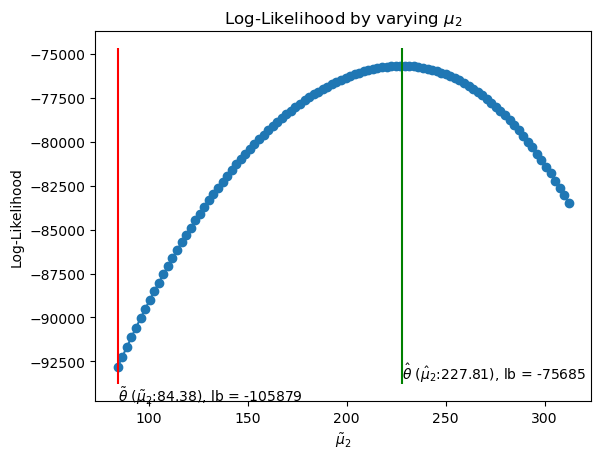

In [19]:

# Solution to Q7 and Q8
temp_mean[1] = temp_mean[0]
lower_bound_value = calculate_lower_bound(flattened_image, num_components, temp_mean, gmm_variances, prior_weights,weights)

new_means = np.nansum(weights*flattened_image,axis=1) / (np.nansum(weights,axis=1))
new_lower_bound_value = calculate_lower_bound(flattened_image, num_components, new_means, gmm_variances, prior_weights,weights)

print(f"Mean for the second GMM component got updated from {round(temp_mean[1],2)} to {round(new_means[1],2)}" )
plt.plot(temp_mu_2, max_log_likelihoods, marker='o')
plt.vlines(x=[temp_mean[1],new_means[1]], ymin=min(max_log_likelihoods)-1000, ymax=max(max_log_likelihoods)+1000, colors=['r','g'])
plt.text(temp_mean[1], min(max_log_likelihoods)-1000, f"$\\tilde\\theta$ ($\\tilde\\mu_2$:{round(temp_mean[1],2)}), lb = {int(lower_bound_value)}", rotation=0, verticalalignment='top')
plt.text(new_means[1], min(max_log_likelihoods)-1000, f"$\hat\\theta$ ($\hat\mu_2$:{round(new_means[1],2)}), lb = {int(new_lower_bound_value)}", rotation=0, verticalalignment='bottom')
plt.title('Log-Likelihood by varying $\\mu_2$')
plt.xlabel('$\\tilde\mu_2$')
plt.ylabel('Log-Likelihood')
plt.show()

In the above figure, $\tilde{\theta}(\tilde{\mu_2})$ refers to the initial parameters setting and $\hat{\theta}(\hat{\mu_2})$ refers to the updated parameters. <br>
lb is the lower bound.<br>

**OBSERVATION:**<br>
1. **The updated mean of the second component ($\hat{\mu_2}$) is set to the value that maximizes the log likelihood value as seen from the figure above**